In [10]:
import pandas as pd
import numpy as np
import networkx as nx
from geopy.distance import geodesic
import matplotlib.pyplot as plt

In [8]:
sb_data = pd.read_csv(r'./santa_barbara_restaurants.csv')
sb_data

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,"131 Anacapa St, Ste C",Santa Barbara,CA,93101,34.414445,-119.690672,4.0,389,1,"{'RestaurantsTakeOut': 'True', 'NoiseLevel': ""...","Food, Restaurants, Salad, Coffee & Tea, Breakf...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-14:0', '..."
1,SZU9c8V2GuREDN5KgyHFJw,Santa Barbara Shellfish Company,230 Stearns Wharf,Santa Barbara,CA,93101,34.408715,-119.685019,4.0,2404,1,"{'OutdoorSeating': 'True', 'RestaurantsAttire'...","Live/Raw Food, Restaurants, Seafood, Beer Bar,...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-21:0', ..."
2,ifjluUv4VASwmFqEp8cWlQ,Marty's Pizza,2733 De La Vina St,Santa Barbara,CA,93105,34.436236,-119.726147,4.0,64,1,"{'Alcohol': ""u'none'"", 'BusinessAcceptsCreditC...","Pizza, Restaurants","{'Tuesday': '11:0-21:30', 'Wednesday': '11:0-2..."
3,UFpCraqzFBAhtZqmxmiWsA,Cat Therapy,"1213 State St, Ste L",Santa Barbara,CA,93101,34.423302,-119.705471,4.5,116,1,"{'WheelchairAccessible': 'True', 'WiFi': ""u'fr...","Themed Cafes, Cafes, Pets, Arts & Entertainmen...","{'Monday': '10:0-17:15', 'Wednesday': '10:0-19..."
4,Hqz96v1ymucUKNzIWfEKXw,Subway,"1936 State St, Ste B",Santa Barbara,CA,93101,34.430822,-119.714156,3.0,5,0,"{'Alcohol': ""u'none'"", 'Caters': 'True', 'Bike...","Restaurants, Delis, Sandwiches, Fast Food","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,Hlx8S2GLF7hMuIKx4sU-gg,Cesar's Place,712 N Milpas St,Santa Barbara,CA,93103,34.428599,-119.688223,4.0,117,1,"{'BYOBCorkage': ""'no'"", 'RestaurantsReservatio...","Mexican, Restaurants, Fish & Chips","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'..."
763,bVaRZDHkWdsHuARGxxpREw,Sushi Bar 29,1134 Chapala St,Santa Barbara,CA,93101,34.422291,-119.705339,4.5,97,1,"{'WiFi': ""u'no'"", 'RestaurantsTableService': '...","Japanese, Restaurants, Noodles, Sushi Bars","{'Monday': '17:0-21:30', 'Tuesday': '17:0-21:3..."
764,izSgTrqebu8bN8ONOCs6cQ,Oat Bakery,5 W Haley St,Santa Barbara,CA,93101,34.416548,-119.695626,5.0,123,1,"{'Alcohol': ""u'none'"", 'HasTV': 'False', 'Bike...","Bakeries, Vegan, Specialty Food, Food Delivery...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-18:0', '..."
765,TSwMwVq5GtQh5LW2t32uGA,Woody's Roundup Bar & Grill,"Earl Warren Showgrounds, 3400 Calle Real",Santa Barbara,CA,93105,34.430895,-119.735645,2.0,6,0,"{'Caters': 'True', 'BusinessParking': ""{'garag...","Barbeque, Bars, Restaurants, Nightlife",NaN


# Calculating the Distance Graph for neo4j

In [9]:
def calculate_distance(latitude_1, longitude_1, latitude_2, longitude_2):
    return geodesic((latitude_1, longitude_1), (latitude_2, longitude_2)).miles

In [ ]:
sb_distance_graph = pd.DataFrame(columns=['restaurant_from', 'restaurant_to', 'distance'])
for i in range(len(sb_data)):
    for j in range(i+1, len(sb_data)):
        sb_distance_graph = pd.concat(
            [
                sb_distance_graph,
                pd.DataFrame(
                    {
                        'restaurant_from': sb_data['business_id'][i],
                        'restaurant_to': sb_data['business_id'][j],
                        'distance': calculate_distance(
                                        latitude_1=sb_data.loc[i, 'latitude'],
                                        longitude_1=sb_data.loc[i, 'longitude'],
                                        latitude_2=sb_data.loc[j, 'latitude'],
                                        longitude_2=sb_data.loc[j, 'longitude']
                                    )
                    },
                    index=[0]
                )
            ],
            ignore_index=True 
        )


In [ ]:
sb_distance_graph

In [ ]:
sb_distance_graph.to_csv("santa_barbara_distance_graph.csv", index=False)

# Calculating the Cuisine Graph for neo4j

## First, we calculate the weighted ratings of the restaurants:

In [12]:
sb_data[['stars', 'review_count']].describe()

,stars,review_count
count,767.000000,767.000000
mean,3.827901,206.319426
std,0.665528,336.432949
min,1.500000,5.000000
25%,3.500000,28.000000
50%,4.000000,88.000000
75%,4.500000,248.500000
max,5.000000,3834.000000


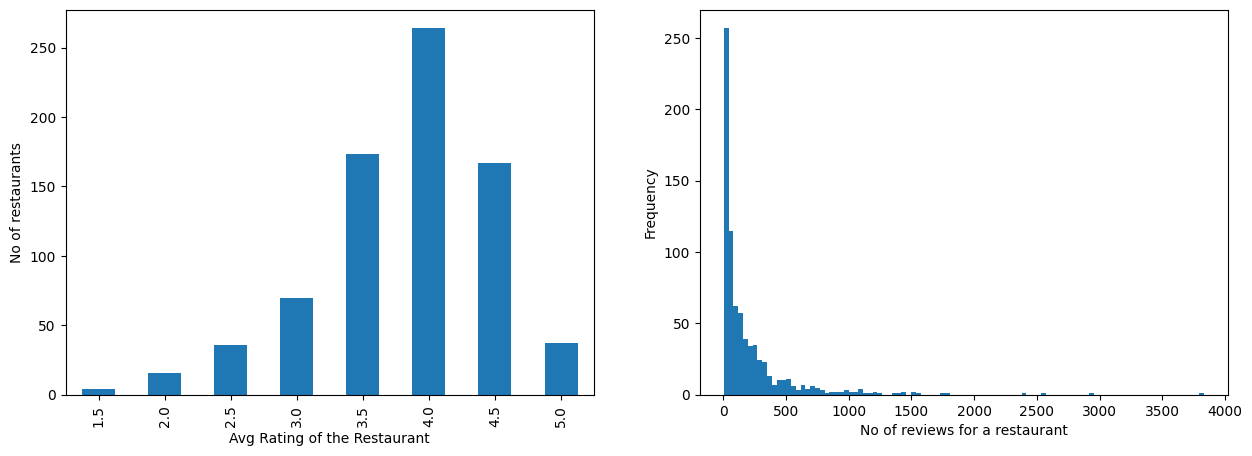

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sb_data.stars.value_counts().sort_index().plot(kind='bar', ax=ax[0])
ax[0].set_xlabel("Avg Rating of the Restaurant")
ax[0].set_ylabel("No of restaurants")

sb_data.review_count.plot(kind='hist', bins=100, ax=ax[1])
ax[1].set_xlabel("No of reviews for a restaurant")
ax[1].set_ylabel("Frequency")

plt.show()

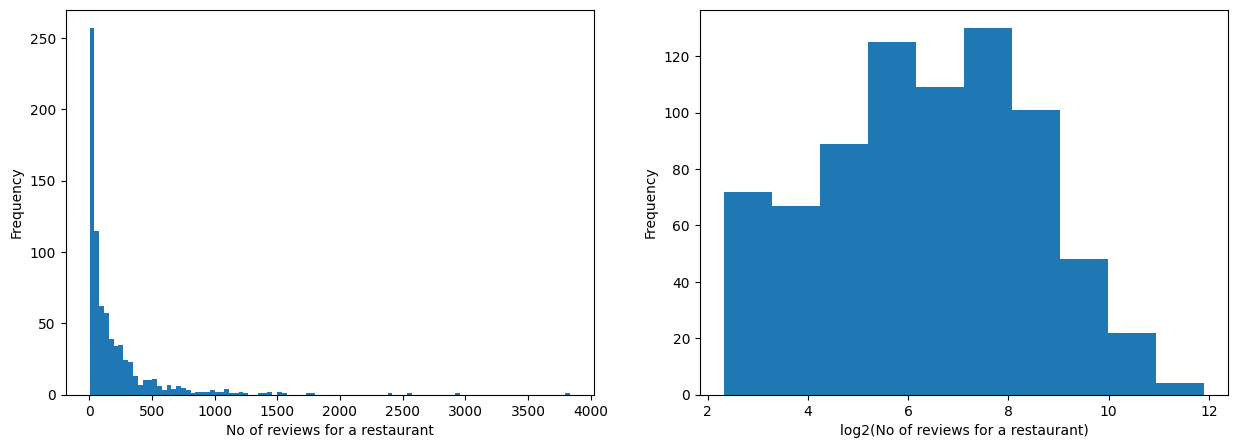

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sb_data.review_count.plot(kind='hist', bins=100, ax=ax[0])
ax[0].set_xlabel("No of reviews for a restaurant")
ax[0].set_ylabel("Frequency")

ax[1].hist(np.log2(sb_data.review_count), bins=10)
ax[1].set_xlabel("log2(No of reviews for a restaurant)")
ax[1].set_ylabel("Frequency")

plt.show()

In [31]:
def get_weighted_rating(row):
    """ This function calculates the weighted rating based on the concept of Bayesian Probability.
    
    :param row: row of df
    :return: rating
    """
    # If we had an unrated restaurant this is the rating that would be assigned to the restaurant.
    initial_belief = sb_data.stars.mean()
    
    # This is the weight assigned to our initial belief i.e. the initial belief is as important as the first 'x' amount of the reviews received by the resturant.
    worth_of_initial_belief = 10
    
    return ((initial_belief * worth_of_initial_belief) + (row['stars'] * row['review_count'])) / (worth_of_initial_belief + row["review_count"])

In [32]:
sb_data['weighted_rating'] = sb_data.apply(get_weighted_rating, axis=1)
sb_data

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,weighted_rating
0,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,"131 Anacapa St, Ste C",Santa Barbara,CA,93101,34.414445,-119.690672,4.0,389,1,"{'RestaurantsTakeOut': 'True', 'NoiseLevel': ""...","Food, Restaurants, Salad, Coffee & Tea, Breakf...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-14:0', '...",3.995687
1,SZU9c8V2GuREDN5KgyHFJw,Santa Barbara Shellfish Company,230 Stearns Wharf,Santa Barbara,CA,93101,34.408715,-119.685019,4.0,2404,1,"{'OutdoorSeating': 'True', 'RestaurantsAttire'...","Live/Raw Food, Restaurants, Seafood, Beer Bar,...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-21:0', ...",3.999287
2,ifjluUv4VASwmFqEp8cWlQ,Marty's Pizza,2733 De La Vina St,Santa Barbara,CA,93105,34.436236,-119.726147,4.0,64,1,"{'Alcohol': ""u'none'"", 'BusinessAcceptsCreditC...","Pizza, Restaurants","{'Tuesday': '11:0-21:30', 'Wednesday': '11:0-2...",3.976743
3,UFpCraqzFBAhtZqmxmiWsA,Cat Therapy,"1213 State St, Ste L",Santa Barbara,CA,93101,34.423302,-119.705471,4.5,116,1,"{'WheelchairAccessible': 'True', 'WiFi': ""u'fr...","Themed Cafes, Cafes, Pets, Arts & Entertainmen...","{'Monday': '10:0-17:15', 'Wednesday': '10:0-19...",4.446659
4,Hqz96v1ymucUKNzIWfEKXw,Subway,"1936 State St, Ste B",Santa Barbara,CA,93101,34.430822,-119.714156,3.0,5,0,"{'Alcohol': ""u'none'"", 'Caters': 'True', 'Bike...","Restaurants, Delis, Sandwiches, Fast Food","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ...",3.551934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,Hlx8S2GLF7hMuIKx4sU-gg,Cesar's Place,712 N Milpas St,Santa Barbara,CA,93103,34.428599,-119.688223,4.0,117,1,"{'BYOBCorkage': ""'no'"", 'RestaurantsReservatio...","Mexican, Restaurants, Fish & Chips","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...",3.986449
763,bVaRZDHkWdsHuARGxxpREw,Sushi Bar 29,1134 Chapala St,Santa Barbara,CA,93101,34.422291,-119.705339,4.5,97,1,"{'WiFi': ""u'no'"", 'RestaurantsTableService': '...","Japanese, Restaurants, Noodles, Sushi Bars","{'Monday': '17:0-21:30', 'Tuesday': '17:0-21:3...",4.437187
764,izSgTrqebu8bN8ONOCs6cQ,Oat Bakery,5 W Haley St,Santa Barbara,CA,93101,34.416548,-119.695626,5.0,123,1,"{'Alcohol': ""u'none'"", 'HasTV': 'False', 'Bike...","Bakeries, Vegan, Specialty Food, Food Delivery...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-18:0', '...",4.911872
765,TSwMwVq5GtQh5LW2t32uGA,Woody's Roundup Bar & Grill,"Earl Warren Showgrounds, 3400 Calle Real",Santa Barbara,CA,93105,34.430895,-119.735645,2.0,6,0,"{'Caters': 'True', 'BusinessParking': ""{'garag...","Barbeque, Bars, Restaurants, Nightlife",NaN,3.142438


Bin width: 0.25


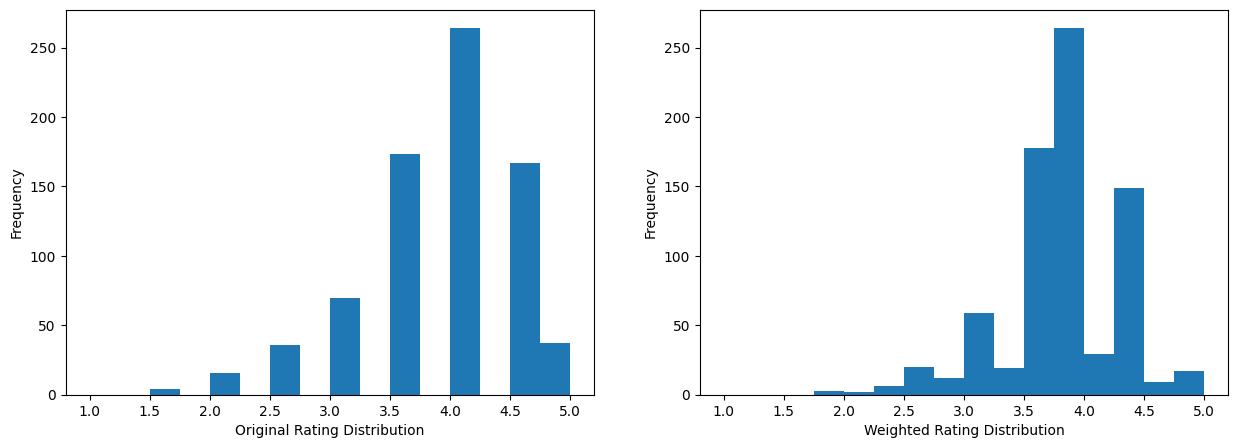

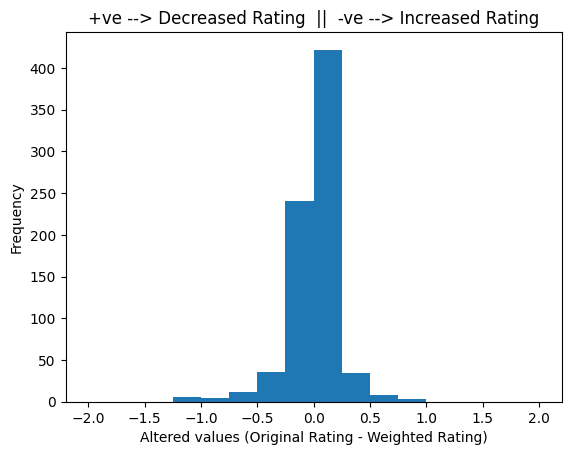

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

bin_width = 0.25
print(f"Bin width: {bin_width}")

sb_data.stars.plot(kind='hist', bins=np.arange(1, 5 + bin_width, bin_width), ax=ax[0])
ax[0].set_xlabel("Original Rating Distribution")
ax[0].set_ylabel("Frequency")

sb_data.weighted_rating.plot(kind='hist', bins=np.arange(1, 5 + bin_width, bin_width), ax=ax[1])
ax[1].set_xlabel("Weighted Rating Distribution")
ax[1].set_ylabel("Frequency")

plt.show()

plt.hist(sb_data.stars - sb_data.weighted_rating, bins=np.arange(-2, 2 + bin_width, bin_width))
plt.xlabel("Altered values (Original Rating - Weighted Rating)")
plt.ylabel("Frequency")
plt.title("+ve --> Decreased Rating  ||  -ve --> Increased Rating")
plt.show()

### Intuition:
The restaurants that have received a high rating on low no of reviews (i.e. 5 stars from only 5 reviews) will gravitate towards the mean rating faster than the restaurants that have received around 4.5 stars from over 1000 reviews and thus the ratings will appear more relevant.

## Second, we unwrap the restaurant categories and organize them for neo4j ingestion

In [47]:
restaurant_categories = set()
count = 0
for categories in sb_data.categories:
    for category in categories.split(', '):
        count+=1
        if category != 'Restaurants':
            restaurant_categories.add(category)
print(len(restaurant_categories))
print(count)

223
3913


In [43]:
sb_restaurant_categories = pd.DataFrame(columns=['business_id', 'category', 'weighted_rating'])
for _, row in sb_data.iterrows():
    for category in row['categories'].split(', '):
        if category != 'Restaurants':
            sb_restaurant_categories = pd.concat(
                [
                    sb_restaurant_categories,
                    pd.DataFrame(
                        {
                            'business_id': row['business_id'],
                            'category': category,
                            'weighted_rating': row['weighted_rating']
                        },
                        index=[0]
                    )
                ],
                ignore_index=True
            )
sb_restaurant_categories

/var/folders/tp/xhg0_2r975dcj4cmr1zw6mbc0000gn/T/ipykernel_30916/1063701362.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sb_restaurant_categories = pd.concat(


,business_id,category,weighted_rating
0,IDtLPgUrqorrpqSLdfMhZQ,Food,3.995687
1,IDtLPgUrqorrpqSLdfMhZQ,Salad,3.995687
2,IDtLPgUrqorrpqSLdfMhZQ,Coffee & Tea,3.995687
3,IDtLPgUrqorrpqSLdfMhZQ,Breakfast & Brunch,3.995687
4,IDtLPgUrqorrpqSLdfMhZQ,Sandwiches,3.995687
...,...,...,...
3141,TSwMwVq5GtQh5LW2t32uGA,Barbeque,3.142438
3142,TSwMwVq5GtQh5LW2t32uGA,Bars,3.142438
3143,TSwMwVq5GtQh5LW2t32uGA,Nightlife,3.142438
3144,uriD7RFuHhLJeDdKaf0nFA,Pizza,3.994430


In [45]:
sb_restaurant_categories.category.unique()

array(['Food', 'Salad', 'Coffee & Tea', 'Breakfast & Brunch',
       'Sandwiches', 'Bakeries', 'Live/Raw Food', 'Seafood', 'Beer Bar',
       'Beer', 'Wine & Spirits', 'Bars', 'Nightlife', 'Pizza',
       'Themed Cafes', 'Cafes', 'Pets', 'Arts & Entertainment',
       "Women's Clothing", 'Shopping', 'Pet Adoption', 'Fashion',
       'Pet Sitting', 'Accessories', 'Pet Stores', 'Pet Services',
       'Delis', 'Fast Food', 'Food Delivery Services', 'Burgers',
       'Caterers', 'Event Planning & Services', 'Wineries', 'Festivals',
       'Food Stands', 'Breweries', 'Food Court', 'Venues & Event Spaces',
       'Wine Tasting Room', 'Shopping Centers', 'Argentine', 'Mexican',
       'American (New)', 'American (Traditional)', 'Chinese', 'German',
       'Hot Dogs', 'Italian', 'Soup', 'Thai', 'Home & Garden',
       'Home Decor', 'Indian', 'Sports Bars', 'Religious Organizations',
       'Churches', 'Tacos', 'Cocktail Bars', 'Club Crawl', 'Vegan',
       'New Mexican Cuisine', 'Tapas Bars', 

In [46]:
sb_restaurant_categories.to_csv('santa_barbara_restaurant_categories.csv', index=False)